In [17]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Matplotlib
sns.set()
W = 8.27
plt.rcParams.update({
    'figure.figsize': (W, W/(4/3)),
    'figure.dpi': 150,
    'font.size' : 11,
    'axes.labelsize': 11,
    'legend.fontsize': 11,
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (
        r'\usepackage{lmodern}'
        r'\usepackage{siunitx}'
        r'\usepackage{physics}'
    )
})
%config InlineBackend.figure_format = 'retina'

In [18]:
env = gym.make('CartPole-v0')    # Simple environment

In [15]:
env.action_space

Discrete(2)

In [19]:
# Random Agent
rewards_test = np.full((1000, 200), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = env.action_space.sample()
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_test[episode, t] = r
        if d: break
        a, obs = env.action_space.sample(), obs_

print(np.mean(np.nansum(rewards_test, 1)))

22.483


In [20]:
# Alternating (trivial) Agent
rewards_test = np.full((1000, 200), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = 1
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_test[episode, t] = r
        if d: break
        a, obs = 1 - a, obs_

print(np.mean(np.nansum(rewards_test, 1)))

38.241


27.28


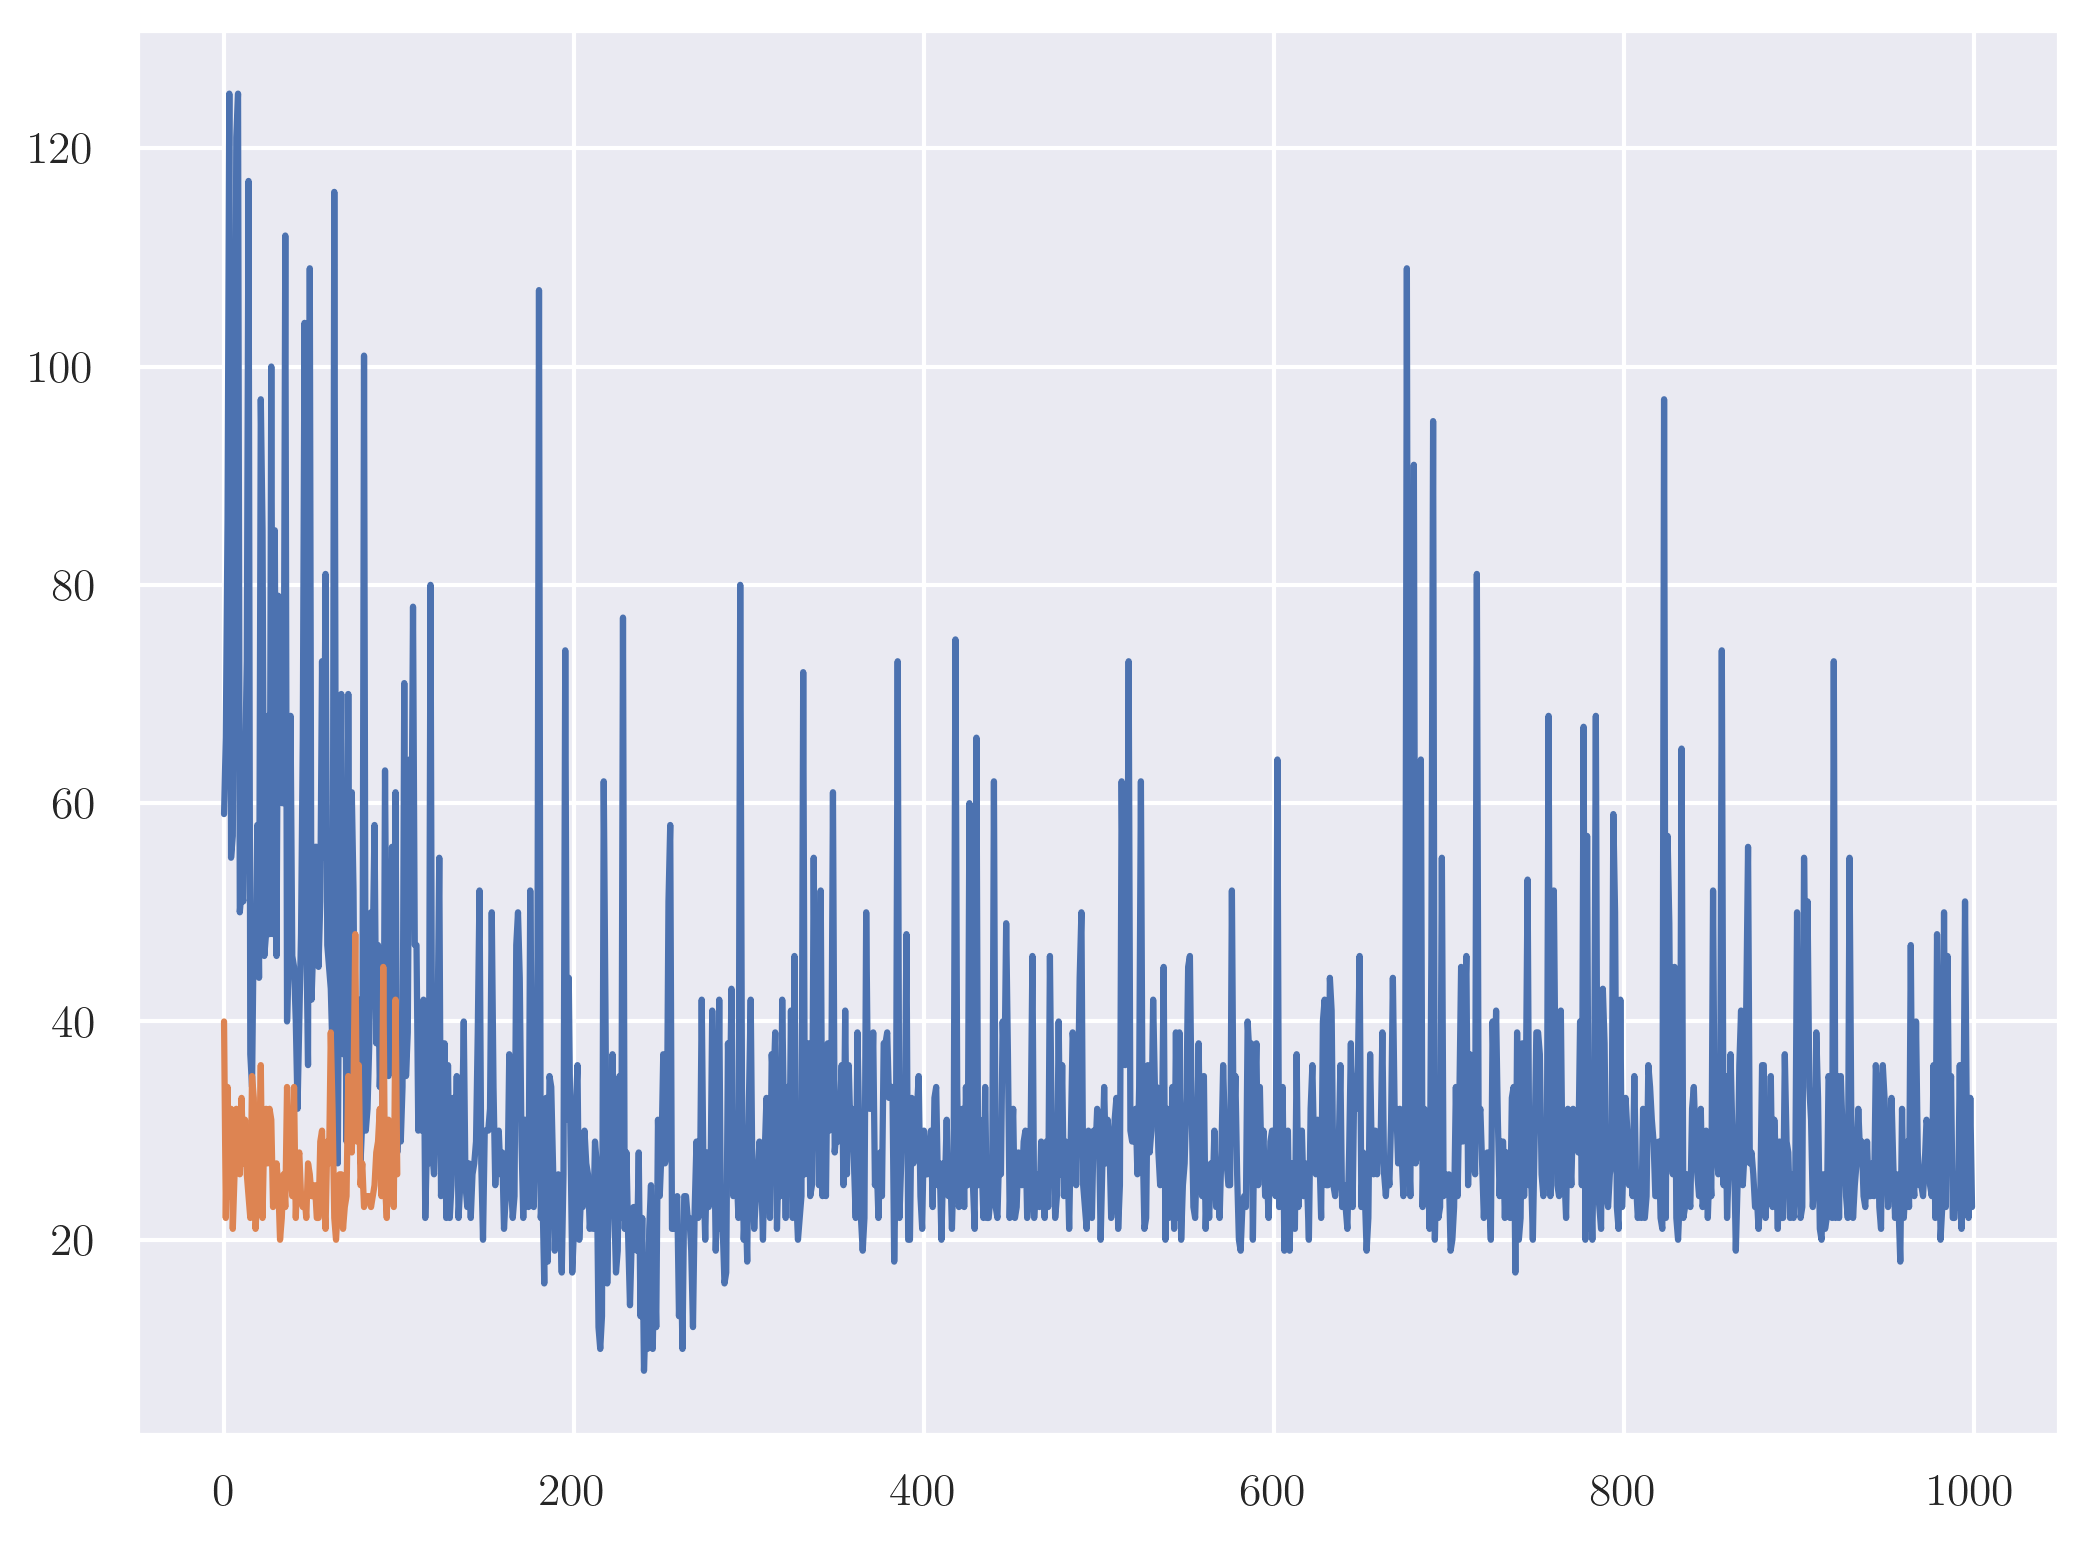

In [39]:
# Hyperparameters
epsilon = 0.1    # No GLIE
alpha = 0.1     # Learning rate
beta = 0         # L2-regularization
discount = 0.5

# Linear Agent
w = np.random.randn(8) * 1e-4                                                         # Weights
x = lambda s, a: np.r_[(2*a - 1)*s, (2*a - 1)*s**2]                                   # Feature vector
q = lambda s, a: w @ x(s, a)                                                          # Approximate Q function
pi = lambda s: max(range(env.action_space.n), key=lambda a: q(s, a))                  # Greedy policy wrt. q(s, a)
pi_ = lambda s: pi(s) if np.random.rand() > epsilon else env.action_space.sample()    # Epsilon-greedy policy

# Learning (Semi-gradient SARSA)
rewards_learn = np.full((1000, 200), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = pi_(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_learn[episode, t] = r
        if d: break
        a_ = pi_(obs_)
        w = (1 - alpha*beta)*w + alpha*np.clip((r + discount*q(obs_, a_) - q(obs, a))*x(obs, a), -1000, 1000)
        a, obs = a_, obs_

# Testing
rewards_test = np.full((100, 200), np.nan)
for episode in range(100):
    obs = env.reset()
    a = pi(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_test[episode, t] = r
        if d: break
        a, obs = pi(obs_), obs_

print(np.mean(np.nansum(rewards_test, 1)))
plt.plot(np.nansum(rewards_learn, 1))
plt.plot(np.nansum(rewards_test, 1))

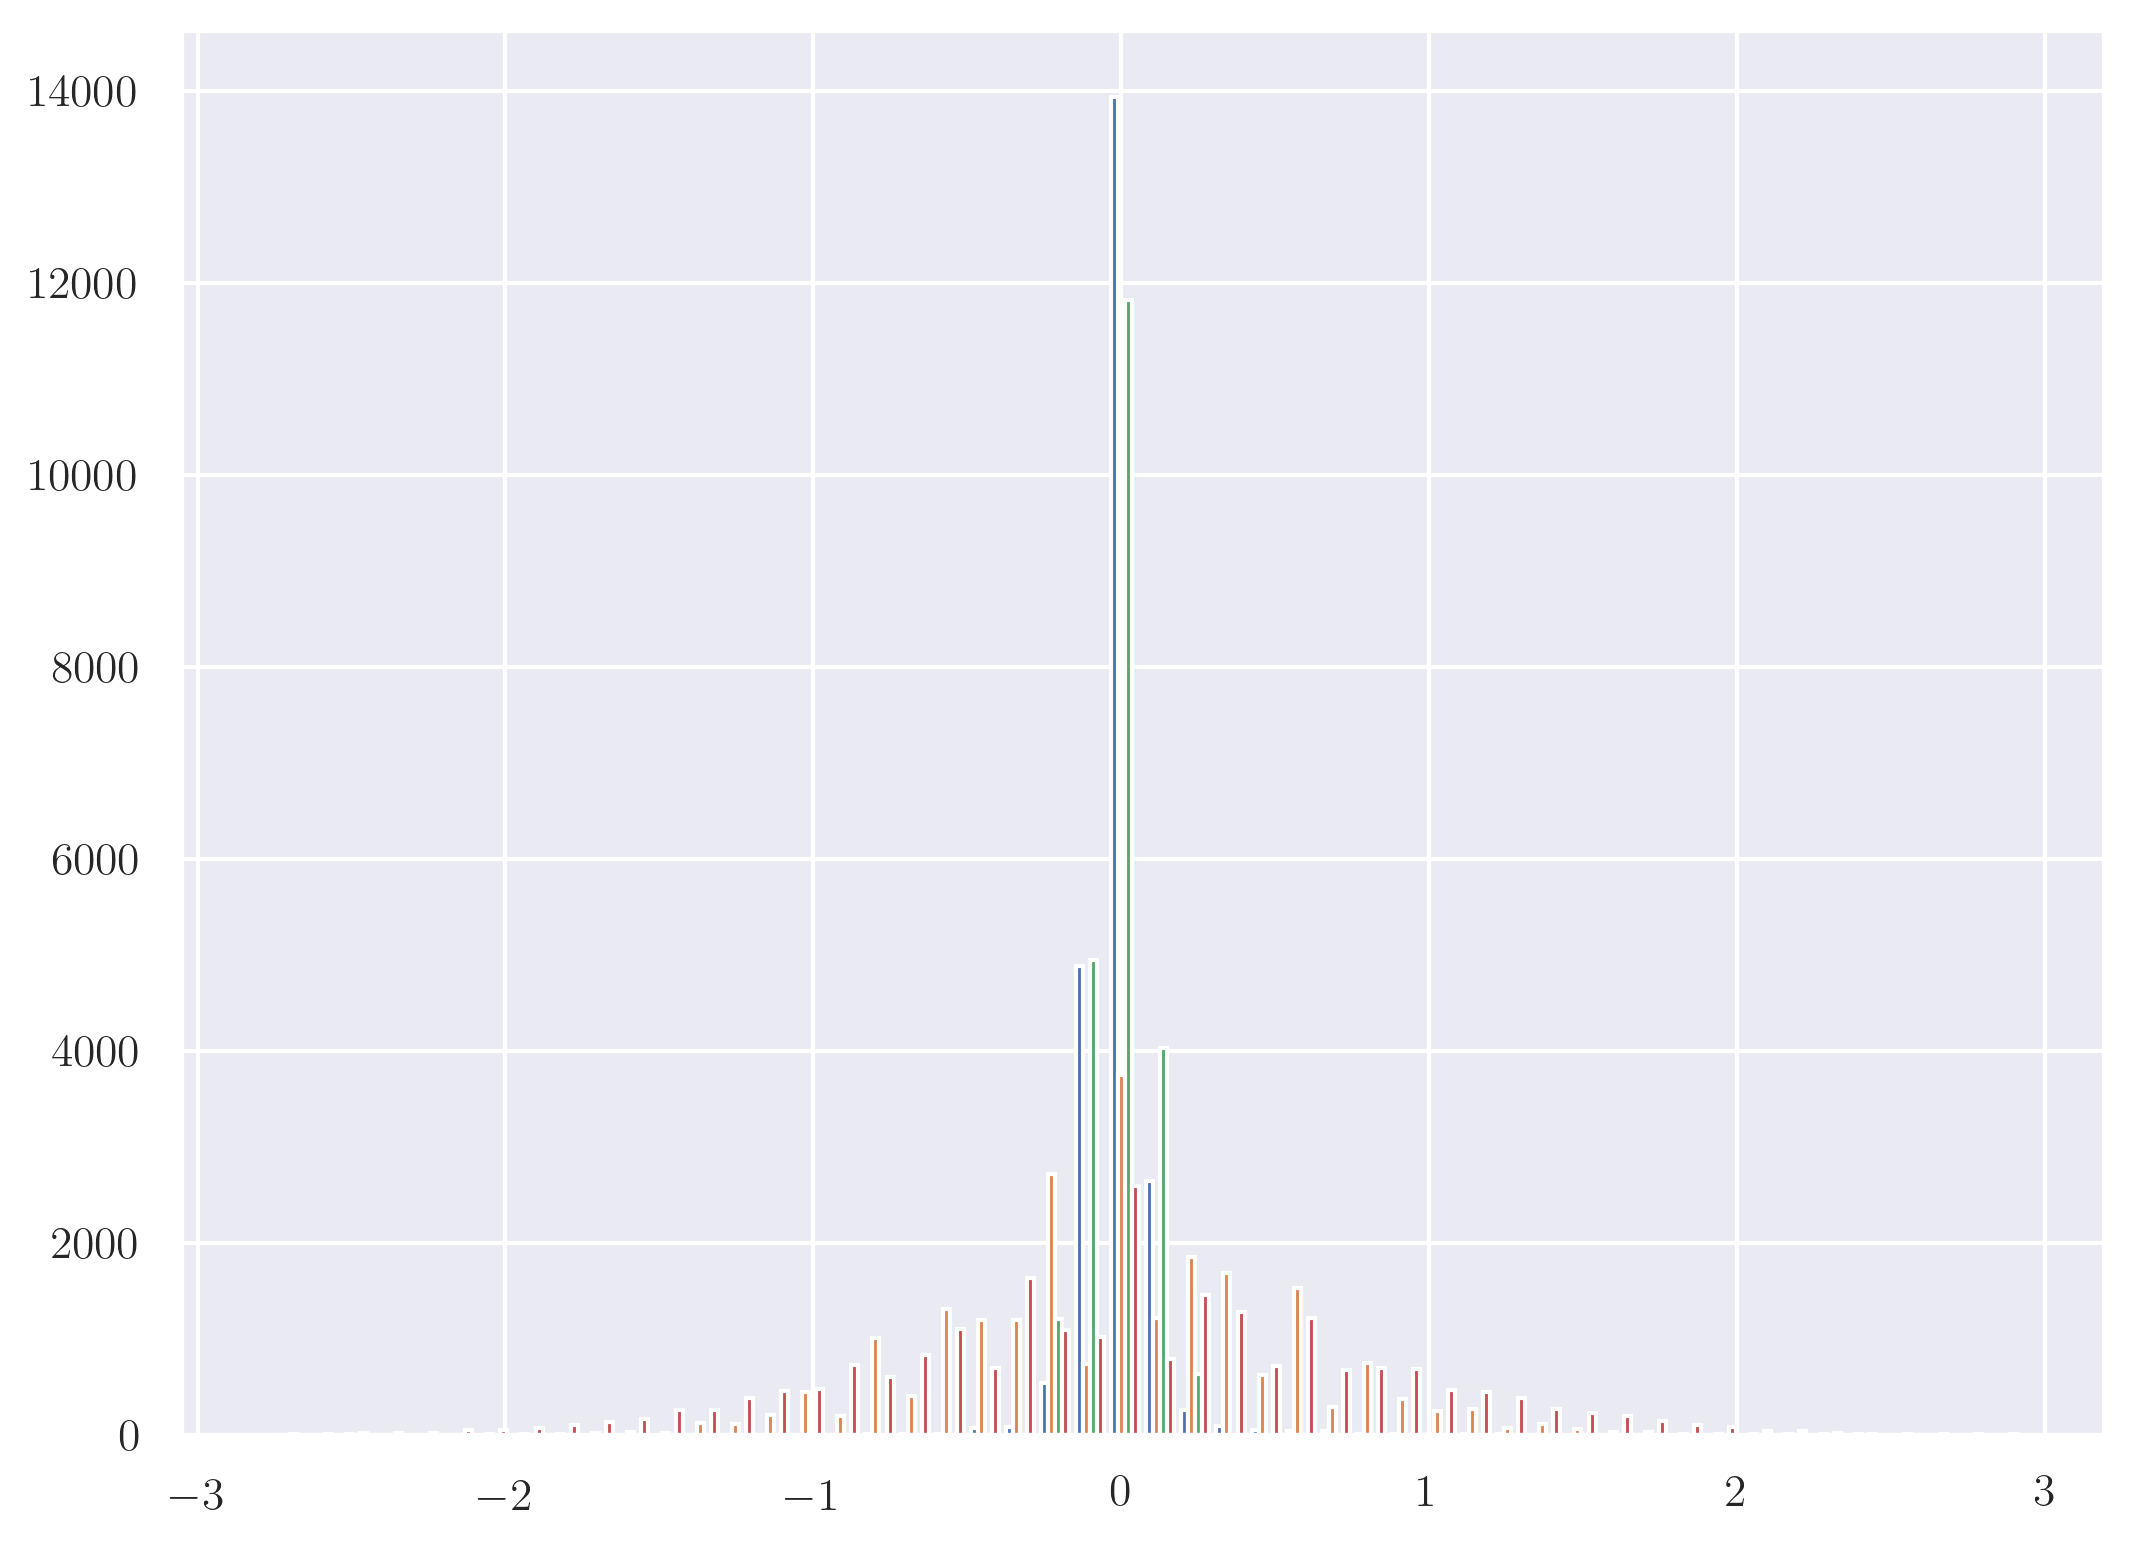

In [11]:
# Random Agent: Find effective observation space for tilings
observations = np.full((1000, 200, 4), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = env.action_space.sample()
    for t in range(200):
        observations[episode, t] = obs
        obs_, r, d, info = env.step(a)
        if d: break
        a, obs = env.action_space.sample(), obs_
        
plt.hist([observations[..., i].flatten() for i in range(4)], 50)
plt.show()

10.03


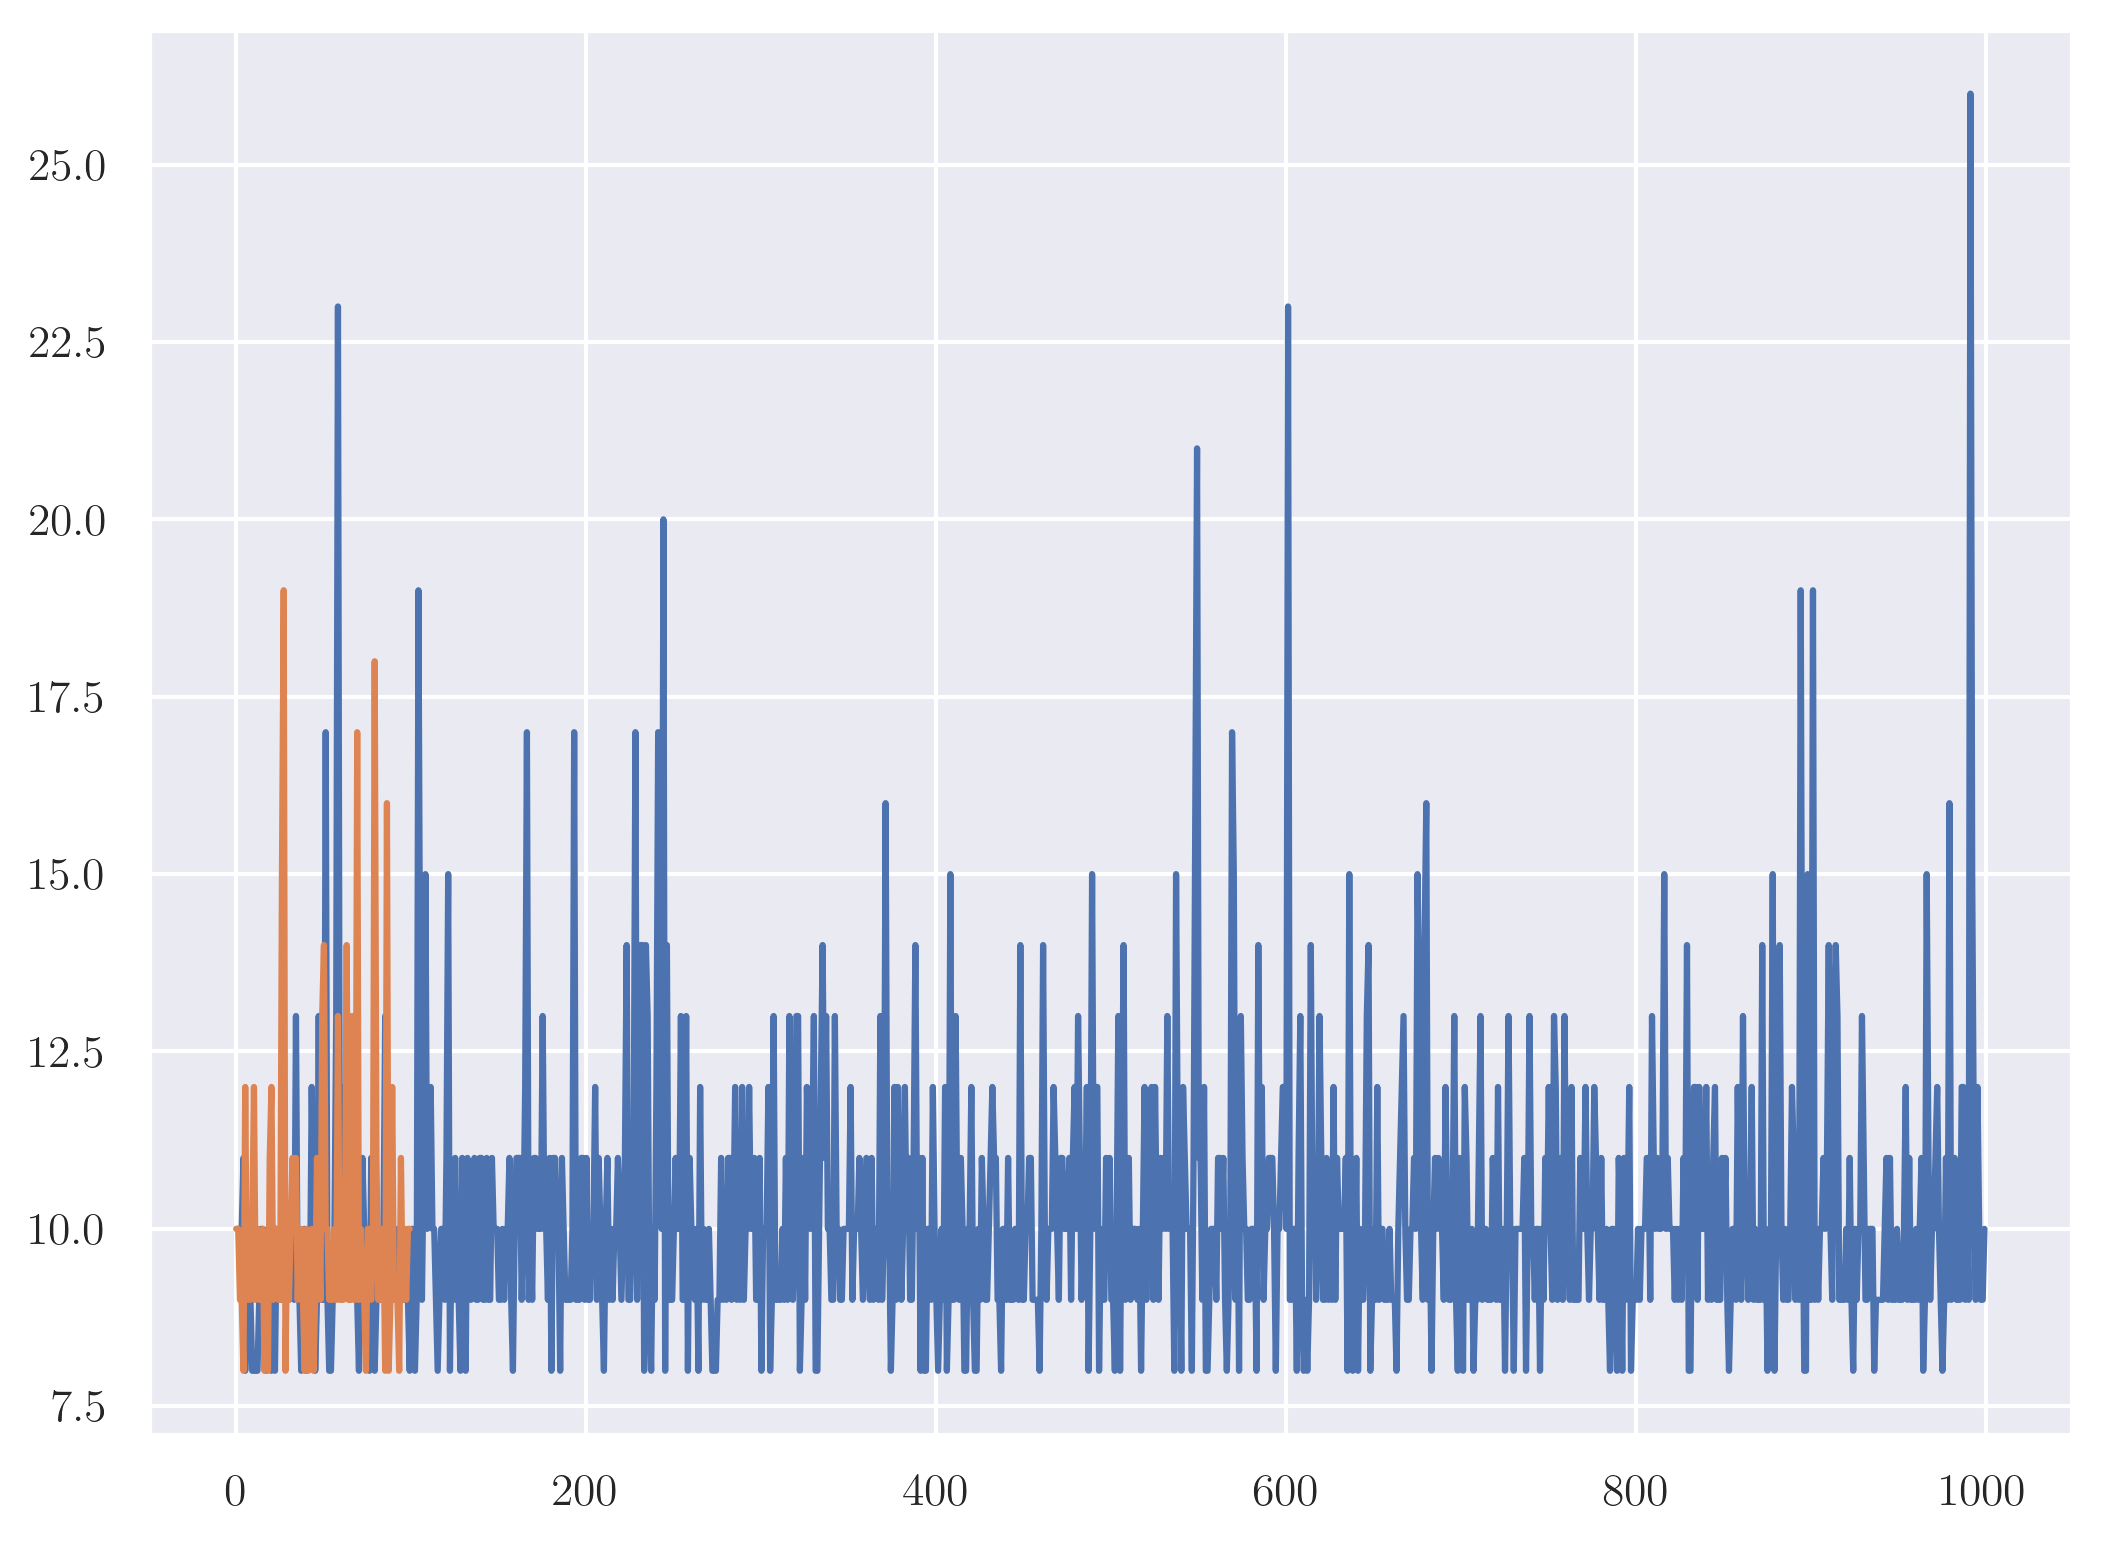

In [29]:
# Hyperparameters
epsilon = 0.1    # No GLIE
alpha = 0.1      # Learning rate
beta = 0         # L2-regularization
discount = 0.9

# State aggregation agent
w = np.zeros((2, 10, 10, 10, 10))    # Weights
def x(s, a):
    """Feature vector"""
    x = np.zeros_like(w)
    x[a, 
      np.digitize(s[0], np.linspace(-.1, .1, 9)), 
      np.digitize(s[1], np.linspace(-.5, .5, 9)), 
      np.digitize(s[2], np.linspace(-.1, .1, 9)), 
      np.digitize(s[3], np.linspace(-.5, .5, 9))] = 1
    return x
    
q = lambda s, a: np.sum(w * x(s, a))                                                  # Approximate Q function
pi = lambda s: max(range(env.action_space.n), key=lambda a: q(s, a))                  # Greedy policy wrt. q(s, a)
pi_ = lambda s: pi(s) if np.random.rand() > epsilon else env.action_space.sample()    # Epsilon-greedy policy

# Learning (Semi-gradient SARSA)
rewards_learn = np.full((1000, 200), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = pi_(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_learn[episode, t] = r
        if d: break
        a_ = pi_(obs_)
        w = (1 - alpha*beta)*w + alpha*np.clip((r + discount*q(obs_, a_) - q(obs, a))*x(obs, a), -1000, 1000)
        a, obs = a_, obs_

# Testing
rewards_test = np.full((100, 200), np.nan)
for episode in range(100):
    obs = env.reset()
    a = pi(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_test[episode, t] = r
        if d: break
        a, obs = pi(obs_), obs_

# Mean reward per episode under learnt policy
print(np.mean(np.nansum(rewards_test, 1)))

# Learning
plt.plot(np.nansum(rewards_learn, 1))
plt.plot(np.nansum(rewards_test, 1))

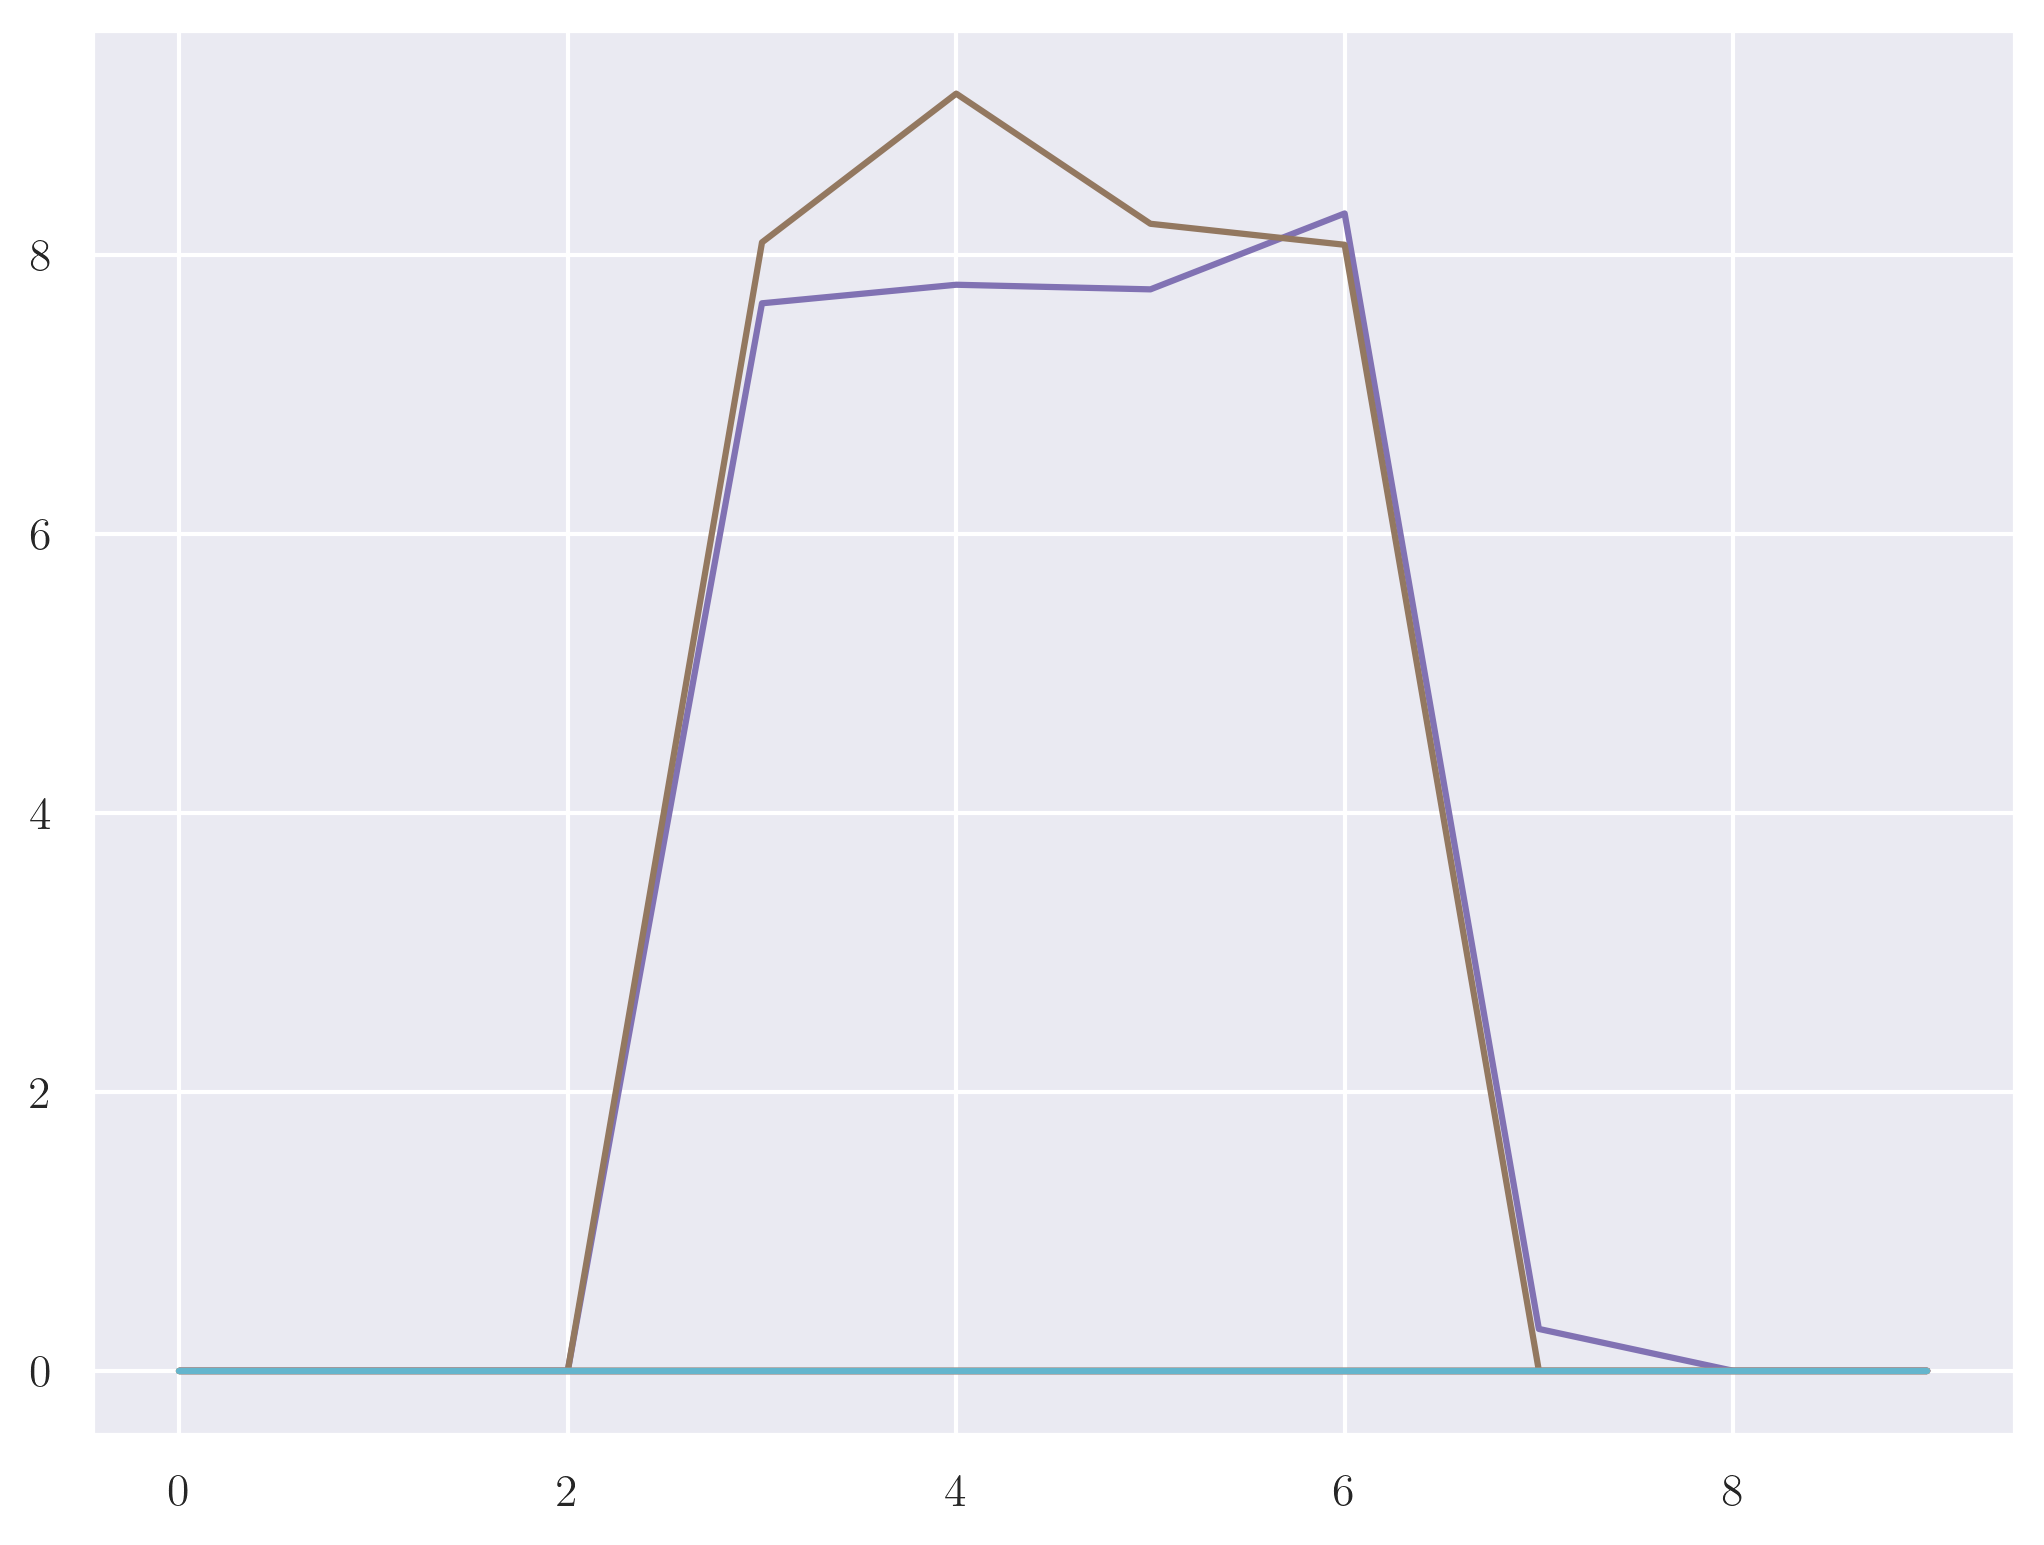

In [13]:
# Analyze learnt value function
for i in range(10):
    plt.plot(np.arange(10), w[0, np.arange(10), i, i, i])

In [ ]:
# Hyperparameters
epsilon = 0.1    # No GLIE
alpha = 0.3      # Learning rate
beta = 0         # L2-regularization
discount = 0.9

# DQN Agent
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

model = DNN()
optim = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()

q = lambda s, a: model(s)[a]                                                          # Approximate Q function
pi = lambda s: max(range(env.action_space.n), key=lambda a: q(s, a))                  # Greedy policy wrt. q(s, a)
pi_ = lambda s: pi(s) if np.random.rand() > epsilon else env.action_space.sample()    # Epsilon-greedy policy

# Learning (Semi-gradient SARSA)
rewards_learn = np.full((1000, 200), np.nan)
for episode in range(1000):
    obs = env.reset()
    a = pi_(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_learn[episode, t] = r
        if d: break
        a_ = pi_(obs_)
        
        optim.zero_grad()
        outputs = model(s)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        w = (1 - alpha*beta)*w + alpha*np.clip((r + discount*q(obs_, a_) - q(obs, a))*x(obs, a), -1000, 1000)
        a, obs = a_, obs_

# Testing
rewards_test = np.full((100, 200), np.nan)
for episode in range(100):
    obs = env.reset()
    a = pi(obs)
    for t in range(200):
        obs_, r, d, info = env.step(a)
        rewards_test[episode, t] = r
        if d: break
        a, obs = pi(obs_), obs_

# Mean reward per episode under learnt policy
print(np.mean(np.nansum(rewards_test, 1)))

# Learning
plt.plot(np.nansum(rewards, 1))